In [1]:
import sys
import matplotlib.pyplot as plt
 
# Avoid AttributeError: module 'sqlalchemy' has no attribute 'orm'
import sqlalchemy.orm  # noqa: F401

sys.path.append("..")
from gmo_hft_bot.db.database import initialize_database
from gmo_hft_bot.db import crud
from backtest.visualize.ohlcv import ohlcv_plot
from backtest.utils.utils import get_ohlcv_df, get_predict_df, match_timestamp_for_ohlcv
from backtest.backtest_trade.richman_backtest import richman_backtest
from backtest.visualize.backtest_visualize import cum_return_plot, position_change_plot, position_change_average_plot


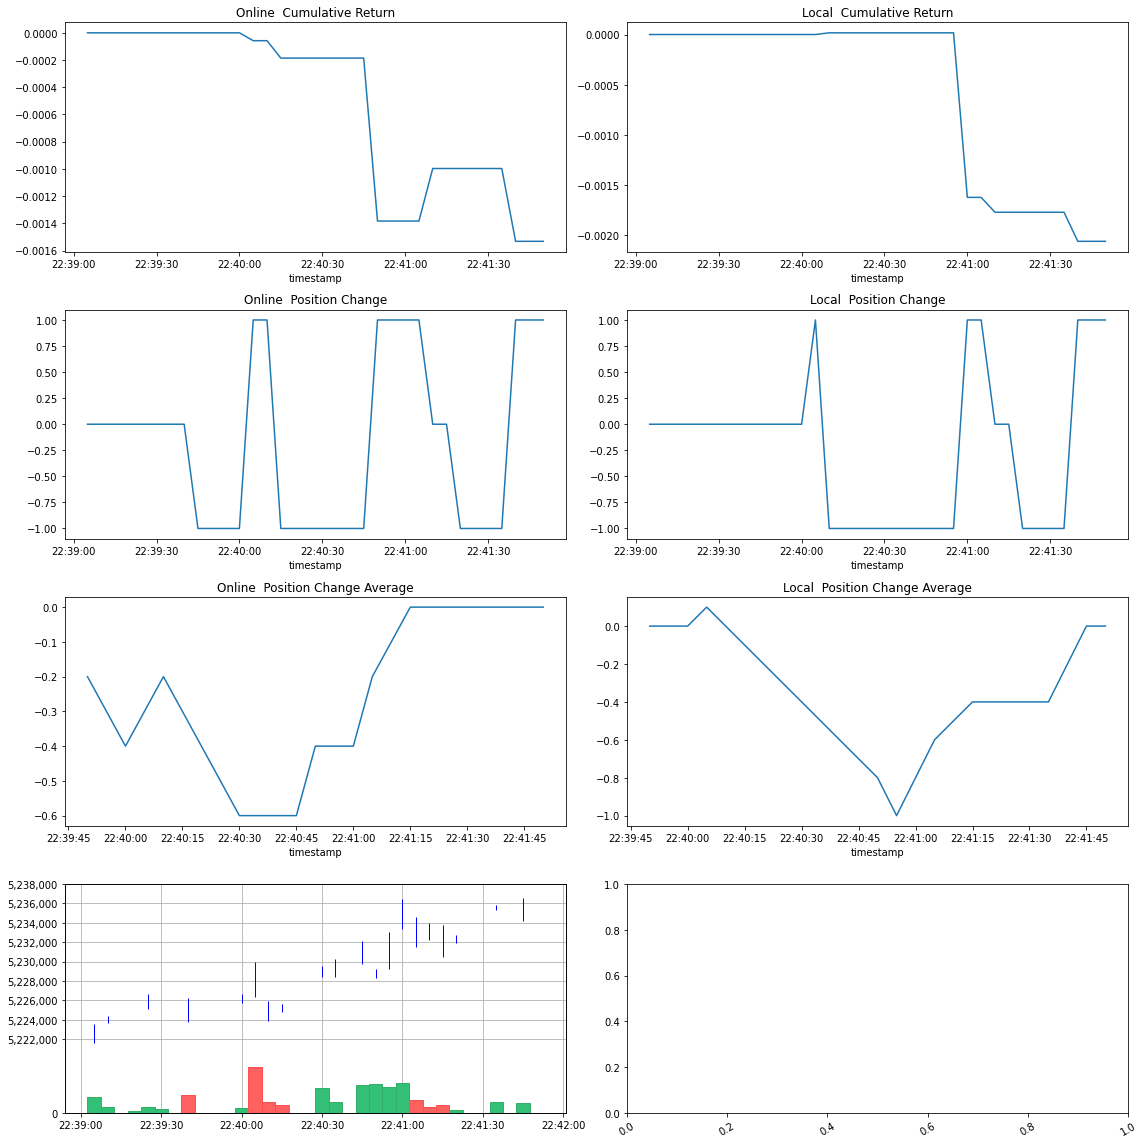

In [2]:
symbol = "BTC_JPY"

_, SessionLocal = initialize_database(uri="sqlite:///../example.db")
with SessionLocal() as db:
    ohlcv_data = crud.get_ohlcv_with_symbol(db=db, symbol=symbol)
    predict_data = crud.get_predict_items(db=db, symbol=symbol)

# fig, axes = plt.subplots(2, 1, figsize=(16, 8))
# axes = axes.flatten()

time_span = 5
ohlcv_df = get_ohlcv_df(ohlcv_data, time_span=time_span)
buy_df, sell_df = get_predict_df(predict_data)
timestamped_buy_df = match_timestamp_for_ohlcv(ohlcv_df, buy_df, time_span)
timestamped_sell_df = match_timestamp_for_ohlcv(ohlcv_df, sell_df, time_span)
timestamped_buy_df["is_entry"] == True
result_online = richman_backtest(ohlcv_df, buy_df=timestamped_buy_df, sell_df=timestamped_sell_df)

# local data backtest
local_timestamped_buy_df = timestamped_buy_df.copy()
local_timestamped_sell_df = timestamped_sell_df.copy()
pips = 1000
local_timestamped_buy_df['price'] = ohlcv_df.loc[:,'close'] - pips
local_timestamped_sell_df['price'] = ohlcv_df.loc[:,'close'] + pips
result_local = richman_backtest(ohlcv_df, buy_df=local_timestamped_buy_df, sell_df=local_timestamped_sell_df)

_, ax = plt.subplots(4, 2, figsize=(16, 16))
ax = ax.flatten()
cum_return_plot(ax[0], result_online["cumulative_return"], 'Online')
cum_return_plot(ax[1], result_local["cumulative_return"], 'Local')
position_change_plot(ax[2], result_online["position"], 'Online')
position_change_plot(ax[3], result_local["position"], 'Local')
position_change_average_plot(ax[4], result_online["position"], 'Online')
position_change_average_plot(ax[5], result_local["position"], 'Local')
ohlcv_plot(ax[6], ohlcv_df)
plt.tight_layout()
plt.show()


In [3]:
pips = 500
ohlcv_df["local_buy_price"] = ohlcv_df["close"] - pips
merged_buy_df = timestamped_buy_df.merge(ohlcv_df["local_buy_price"], right_index=True, left_index=True)
merged_buy_df["subt_online_local"] = merged_buy_df["price"] - merged_buy_df["local_buy_price"]
merged_buy_df[['price', "local_buy_price", "subt_online_local"]].tail(30)

,price,local_buy_price,subt_online_local
timestamp,,,
2022-03-24 22:39:25+00:00,5222824.0,5226189.0,-3365.0
2022-03-24 22:39:30+00:00,5224860.0,5226127.0,-1267.0
2022-03-24 22:39:35+00:00,5226897.0,5225713.0,1184.0
2022-03-24 22:39:40+00:00,5226711.0,5224300.0,2411.0
2022-03-24 22:39:45+00:00,5224723.0,5225254.0,-531.0
2022-03-24 22:39:50+00:00,5223302.0,5225254.0,-1952.0
2022-03-24 22:39:55+00:00,5222955.0,5225208.0,-2253.0
2022-03-24 22:40:00+00:00,5223385.0,5225997.0,-2612.0
2022-03-24 22:40:05+00:00,5225101.0,5225845.0,-744.0


In [4]:
ohlcv_df.tail(40)

,open,high,low,close,volume,local_buy_price
timestamp,,,,,,
2022-03-24 22:39:05+00:00,5221764.0,5223580.0,5221598.0,5223580.0,0.55,5223080.0
2022-03-24 22:39:10+00:00,5223643.0,5224432.0,5223643.0,5224298.0,0.22,5223798.0
2022-03-24 22:39:15+00:00,5224298.0,5224298.0,5224298.0,5224298.0,0.00,5223798.0
2022-03-24 22:39:20+00:00,5224989.0,5224989.0,5224989.0,5224989.0,0.06,5224489.0
2022-03-24 22:39:25+00:00,5225121.0,5226689.0,5225121.0,5226689.0,0.22,5226189.0
2022-03-24 22:39:30+00:00,5226627.0,5226710.0,5226627.0,5226627.0,0.16,5226127.0
2022-03-24 22:39:35+00:00,5226213.0,5226213.0,5226213.0,5226213.0,0.02,5225713.0
2022-03-24 22:39:40+00:00,5226244.0,5226244.0,5223746.0,5224800.0,0.64,5224300.0
2022-03-24 22:39:45+00:00,5225754.0,5225754.0,5225754.0,5225754.0,0.02,5225254.0
